# All the plots for the MDM paper

In [2]:
import numpy as np
import xarray as xr
from distributed import Client
import dask_jobqueue
import matplotlib.pyplot as plt
import matplotlib as mtplt
import glob
# import netCDF4 as nc
import zarr
import nc_time_axis
import xskillscore as xs
import cartopy as cart
#np.set_printoptions(threshold=np.inf)
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from datetime import datetime, timedelta
import pandas as pd
import random
from scipy.special import erfinv, erf

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/numba/core/cpu.py:78: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ContextualVersionConflict((numpy 1.23.5 (/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages), Requirement.parse('numpy<1.23.0,>=1.16.5'), {'scipy'}))'.
  numba.core.entrypoints.init_all()
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/numba/core/cpu.py:78: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ContextualVersionConflict((numpy 1.23.5 (/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages), Requirement.parse('numpy<1.2

In [3]:
#
sgp_lat   = 36.607
sgp_lon   = (360-97.487)%360

#36.607322° N and 97.487643° W
########## CONUS ############
#CONUS lat-lon
top       = 50.0 # north lat
left      = -124.7844079+360 # west long
right     = -66.9513812+360 # east long
bottom    =  24.7433195 # south lat
################################
cesm2_path    = '/global/scratch/users/harsha/LENS/cesm2/tasmax/'
sgp_path     =  '/global/scratch/users/harsha/SGP/'
loc1       = 'SGP/'
locn1      = 'SGP'
#
cesm2_path = '/global/scratch/users/harsha/LENS/cesm2/tasmax/'
cvals_bias = '/global/scratch/users/harsha/LENS/cesm2/cvals/bias/'
cvals_det      = '/global/scratch/users/harsha/LENS/cesm2/cvals/detrended/'
cvals      = '/global/scratch/users/harsha/LENS/cesm2/cvals/'
print(sgp_lat,sgp_lon)
#
pi_year  = 1865
eoc_year = 2085
#
doy  = 211
#
pi_year0  = '1850'
pi_year1  = '1879'
ic_year0  = '2071'
ic_year1  = '2100'

36.607 262.51300000000003


In [4]:
def no_leap_date(day_of_year):
    # Start from the first day of a non-leap year
    start_date = datetime(2021, 1, 1)

    # Calculate the actual date (subtract 1 because January 1st is day 1)
    actual_date = start_date + timedelta(days=day_of_year - 1)

    # Format the date to get 'Month Day'
    return actual_date.strftime('%B %d')
###############################
date = no_leap_date(doy)
date
date0     = 'Jul30'

In [5]:
def gauss_quantile(mean,std,quantile):
    #quantile must be a real number neteoceen 0 and 1
    qvalue = mean + std * np.sqrt(2) * erfinv(2*quantile-1)
    return qvalue

def to_daily(ds):
    year = ds.time.dt.year
    day = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), day=("time", day.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "day")).unstack("time")  

In [6]:
# calculate global means
def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'year'}
    return (ds * weight).mean(other_dims)

In [7]:
job_extra = ['--qos=cf_lowprio','--account=ac_cumulus'] 
#job_extra =['--qos=lr6_lowprio','--account=ac_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=condo_cumulus_lr6','--account=lr_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=lr_lowprio','--account=ac_cumulus']
cluster = dask_jobqueue.SLURMCluster(queue="cf1", cores=10, walltime='5:00:00', 
                local_directory='/global/scratch/users/harsha/dask_space/', 
                log_directory='/global/scratch/users/harsha/dask_space/', 
                job_extra_directives=job_extra, interface='eth0', memory="192GB") 
client  = Client(cluster) 
cluster.scale_up(3)

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 32851 instead
  warnings.warn(


In [8]:
cluster

Dashboard: http://10.0.39.5:32851/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.39.5:44083,Workers: 0
Dashboard: http://10.0.39.5:32851/status,Total threads: 0
Started: Just now,Total memory: 0 B


### GMST

In [9]:
%%time
ds_ssp  = xr.open_mfdataset(cesm2_path+'ssp370_cesm2tmax.zarr',engine='zarr')
ds_hist = xr.open_mfdataset(cesm2_path+'bhist_cesm2tmax.zarr',engine='zarr')

CPU times: user 2.91 s, sys: 470 ms, total: 3.38 s
Wall time: 3.49 s


In [10]:
%%time
#t-temp, nw - no-warming, w-warming, ssn= season, g=global
pi_hist  = ds_hist.TREFHTMX.sel(time=slice(pi_year0,pi_year1))
eoc_ssp  = ds_ssp.TREFHTMX.sel(time=slice(ic_year0,ic_year1))

CPU times: user 848 ms, sys: 19 ms, total: 867 ms
Wall time: 854 ms


In [11]:
ds_pi  = to_daily(pi_hist)
ds_eoc = to_daily(eoc_ssp)

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/dataset.py:4880: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._unstack_full_reindex(
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/dataset.py:4880: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

In [12]:
gmst_pi  = global_mean(ds_pi)
gmst_eoc = global_mean(ds_eoc)
gmst_pi

<xarray.DataArray (year: 30)>
dask.array<mean_agg-aggregate, shape=(30,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 1875 1876 1877 1878 1879

In [13]:
gmsta = gmst_eoc.mean('year') - gmst_pi.mean('year')

In [14]:
gmst_eoc

<xarray.DataArray (year: 30)>
dask.array<mean_agg-aggregate, shape=(30,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 2071 2072 2073 2074 2075 ... 2096 2097 2098 2099 2100

In [15]:
# %%time
# gmsta.values

### Plot 2

In [16]:
%%time
#
dpi_detpath1      = cvals_det+loc1+'tpi_det'+date0+'_'+pi_year0+'_'+pi_year1+'_loc.zarr'
deoc_detpath1     = cvals_det+loc1+'teoc_det'+date0+'_'+ic_year0+'_'+ic_year1+'_loc.zarr'
dmsc_detpath1     = cvals_det+loc1+'tmsc_det'+date0+'_'+ic_year0+'_'+ic_year1+'_loc.zarr'
dmc_detpath1      = cvals_det+loc1+'tmc_det'+date0+'_'+ic_year0+'_'+ic_year1+'_loc.zarr'
#
tpi_loc1_det     = xr.open_zarr(dpi_detpath1).detrended_tmax
teoc_loc1_det    = xr.open_zarr(deoc_detpath1).detrended_tmax
tmc_loc1_det     = xr.open_zarr(dmc_detpath1).detrended_tmax
tmsc_loc1_det    = xr.open_zarr(dmsc_detpath1).detrended_tmax

CPU times: user 224 ms, sys: 19.8 ms, total: 243 ms
Wall time: 242 ms


In [17]:
%%time
# Get the Gaussian candidate distrubutions for the EOC period.
quants      = np.arange(0.0,1.01,0.01)
#
qeocgauss_loc1_det = gauss_quantile(teoc_loc1_det.mean().values,teoc_loc1_det.std().values,quants)
qeocgauss_loc1_det = xr.DataArray(qeocgauss_loc1_det, coords={'quantile': quants}, dims=["quantile"])
#
qpigauss_loc1_det  = gauss_quantile(tpi_loc1_det.mean().values,tpi_loc1_det.std().values,quants)
qpigauss_loc1_det  = xr.DataArray(qpigauss_loc1_det, coords={'quantile': quants}, dims=["quantile"])

CPU times: user 12.2 s, sys: 515 ms, total: 12.8 s
Wall time: 37.9 s


### Plot 5

In [18]:
%%time
# qgmw_grmsepath   = cvals+'qgmw_grmse'+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgmc_gmaepath     = cvals+'qgmc_gmae'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgmsc_gmaepath    = cvals+'qgmsc_gmae'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgauss_gmaepath   = cvals+'qgauss_gmae'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgaussmo_gmaepath = cvals+'qgaussmo_gmae'+'_'+ic_year0+'_'+ic_year1+'.zarr'

CPU times: user 28 µs, sys: 3 µs, total: 31 µs
Wall time: 45.5 µs


In [19]:
%%time
qgmc_gmae     = xr.open_zarr(qgmc_gmaepath).Error
qgmsc_gmae    = xr.open_zarr(qgmsc_gmaepath).Error
qgauss_gmae   = xr.open_zarr(qgauss_gmaepath).Error
qgaussmo_gmae = xr.open_zarr(qgaussmo_gmaepath).Error

CPU times: user 185 ms, sys: 23.4 ms, total: 209 ms
Wall time: 204 ms


In [20]:
qgauss_gmae.loc[dict(quantile=0)]=1e10
qgauss_gmae.loc[dict(quantile=1)]=1e10
# qgauss_gmae.values
qgaussmo_gmae.loc[dict(quantile=0)]=1e10
qgaussmo_gmae.loc[dict(quantile=1)]=1e10
qgaussmo_gmae.values

array([1.00000000e+10, 8.76158514e-01, 7.45351180e-01, 6.70017518e-01,
       6.17109782e-01, 5.76397158e-01, 5.43324074e-01, 5.15452826e-01,
       4.91335247e-01, 4.70036683e-01, 4.50935123e-01, 4.33616763e-01,
       4.17780400e-01, 4.03203226e-01, 3.89711609e-01, 3.77158033e-01,
       3.65428463e-01, 3.54429552e-01, 3.44090356e-01, 3.34355517e-01,
       3.25151774e-01, 3.16450682e-01, 3.08218146e-01, 3.00411168e-01,
       2.92999622e-01, 2.85931437e-01, 2.79183606e-01, 2.72726772e-01,
       2.66520646e-01, 2.60558479e-01, 2.54813373e-01, 2.49270867e-01,
       2.43916601e-01, 2.38727150e-01, 2.33697181e-01, 2.28808964e-01,
       2.24045603e-01, 2.19396582e-01, 2.14855471e-01, 2.10411276e-01,
       2.06052414e-01, 2.01773733e-01, 1.97570980e-01, 1.93446982e-01,
       1.89387634e-01, 1.85403548e-01, 1.81497720e-01, 1.77681091e-01,
       1.73963052e-01, 1.70377554e-01, 1.67057035e-01, 1.64317180e-01,
       1.62279228e-01, 1.61113828e-01, 1.60744131e-01, 1.61089130e-01,
      

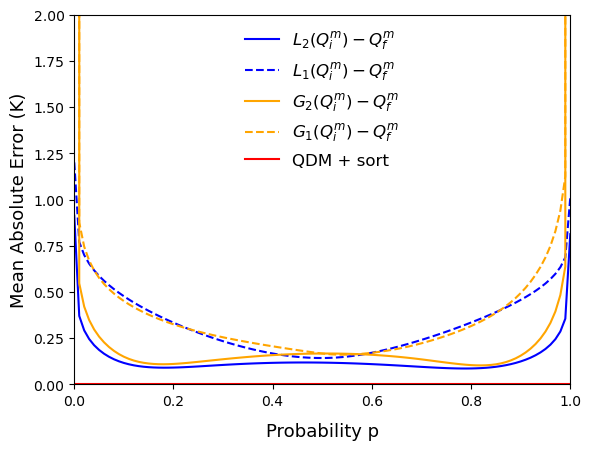

CPU times: user 7.2 s, sys: 411 ms, total: 7.61 s
Wall time: 13.8 s


In [21]:
%%time
plt.plot(quants,qgmsc_gmae,label=r'$L_2(Q_i^m)-Q_f^m$',color='blue')
plt.plot(quants,qgmc_gmae,'--',label = r'$L_1(Q_i^m) - Q_f^m$',color='blue')
plt.plot(quants,qgauss_gmae,label=r'$G_2(Q_i^m) - Q_f^m$',color='orange')
plt.plot(quants,qgaussmo_gmae,'--',label = r'$G_1(Q_i^m) - Q_f^m$',color='orange')
#plt.plot(quants30,qano_std_agmean,'-.',color='tab:gray',markersize=4)
# specifying horizontal line type 
plt.axhline(y = 0,label = 'QDM + sort', color = 'r') 
plt.legend(loc='upper center',prop={'size':12},frameon=False)
plt.title('')
plt.ylabel('Mean Absolute Error (K)',fontsize=13)
plt.xlabel('Probability p',fontsize=13,labelpad=10)
plt.xlim(0.0,1.0)
plt.ylim(0.0,2.0)
plt.show()

### Plot 6

In [22]:
average_mdm_mae  = xr.open_zarr(cvals_det + 'mdm_mae_avg100pairs.zarr').tmax
average_sqdm_mae = xr.open_zarr(cvals_det + 'sqdm_mae_avg100pairs.zarr').tmax
average_sqdm_mae 

<xarray.DataArray 'tmax' (quantile: 30)>
dask.array<open_dataset-7ea99a5c5158530ca8cf3be4879f4dcctmax, shape=(30,), dtype=float64, chunksize=(30,), chunktype=numpy.ndarray>
Coordinates:
  * quantile  (quantile) float64 0.0 0.03448 0.06897 0.1034 ... 0.931 0.9655 1.0

In [23]:
%%time
cmip6_average_mdm_mae  = xr.open_zarr(cvals_det + 'cmip6_mdm_mae_avg306pairs.zarr').tmax
cmip6_average_sqdm_mae = xr.open_zarr(cvals_det + 'cmip6_sqdm_mae_avg306pairs.zarr').tmax
cmip6_average_sqdm_mae

CPU times: user 49.1 ms, sys: 13.9 ms, total: 63 ms
Wall time: 82.2 ms


<xarray.DataArray 'tmax' (quantile: 30)>
dask.array<open_dataset-cee556cca931529702544ffbda8fa8b0tmax, shape=(30,), dtype=float64, chunksize=(30,), chunktype=numpy.ndarray>
Coordinates:
  * quantile  (quantile) float64 0.0 0.03448 0.06897 0.1034 ... 0.931 0.9655 1.0

In [24]:
%%time
qgmc_gmaepath     = cvals+'qgmc_gmae'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgmsc_gmaepath    = cvals+'qgmsc_gmae'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgmc_gmae     = xr.open_zarr(qgmc_gmaepath).Error
qgmsc_gmae    = xr.open_zarr(qgmsc_gmaepath).Error
qgmsc_gmae 

CPU times: user 72.2 ms, sys: 14.5 ms, total: 86.7 ms
Wall time: 143 ms


<xarray.DataArray 'Error' (quantile: 101)>
dask.array<open_dataset-c7ed84a8ebd64f9037a2553cc81c71c0Error, shape=(101,), dtype=float64, chunksize=(101,), chunktype=numpy.ndarray>
Coordinates:
    member    int64 ...
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0
    year      int64 ...
    ym        int64 ...

In [25]:
average_mdm_mae.values

array([1.36598288, 1.1060247 , 0.98793918, 0.91503208, 0.8643774 ,
       0.82683579, 0.79792721, 0.77495322, 0.7564878 , 0.74148701,
       0.72927492, 0.71938895, 0.71149736, 0.70533693, 0.70082211,
       0.69791927, 0.69656248, 0.69685584, 0.69880588, 0.70259881,
       0.70861819, 0.71726845, 0.72910836, 0.74486352, 0.7659969 ,
       0.79463505, 0.83438515, 0.89292902, 0.98990347, 1.20634948])

In [26]:
average_sqdm_mae.values

array([1.38040481, 1.09560711, 0.98256733, 0.91730608, 0.87353822,
       0.84167949, 0.81728774, 0.79776791, 0.78187548, 0.76871045,
       0.75769006, 0.74848729, 0.7408075 , 0.73449382, 0.72943391,
       0.72561392, 0.72298339, 0.721543  , 0.72134761, 0.72245912,
       0.72517736, 0.72984905, 0.73691867, 0.74696349, 0.76125229,
       0.7817429 , 0.81182411, 0.85927722, 0.94539224, 1.16907442])

In [27]:
average_sqdm_mae

<xarray.DataArray 'tmax' (quantile: 30)>
dask.array<open_dataset-7ea99a5c5158530ca8cf3be4879f4dcctmax, shape=(30,), dtype=float64, chunksize=(30,), chunktype=numpy.ndarray>
Coordinates:
  * quantile  (quantile) float64 0.0 0.03448 0.06897 0.1034 ... 0.931 0.9655 1.0

CPU times: user 6.76 s, sys: 317 ms, total: 7.08 s
Wall time: 17.6 s


(0.0, 2.0)

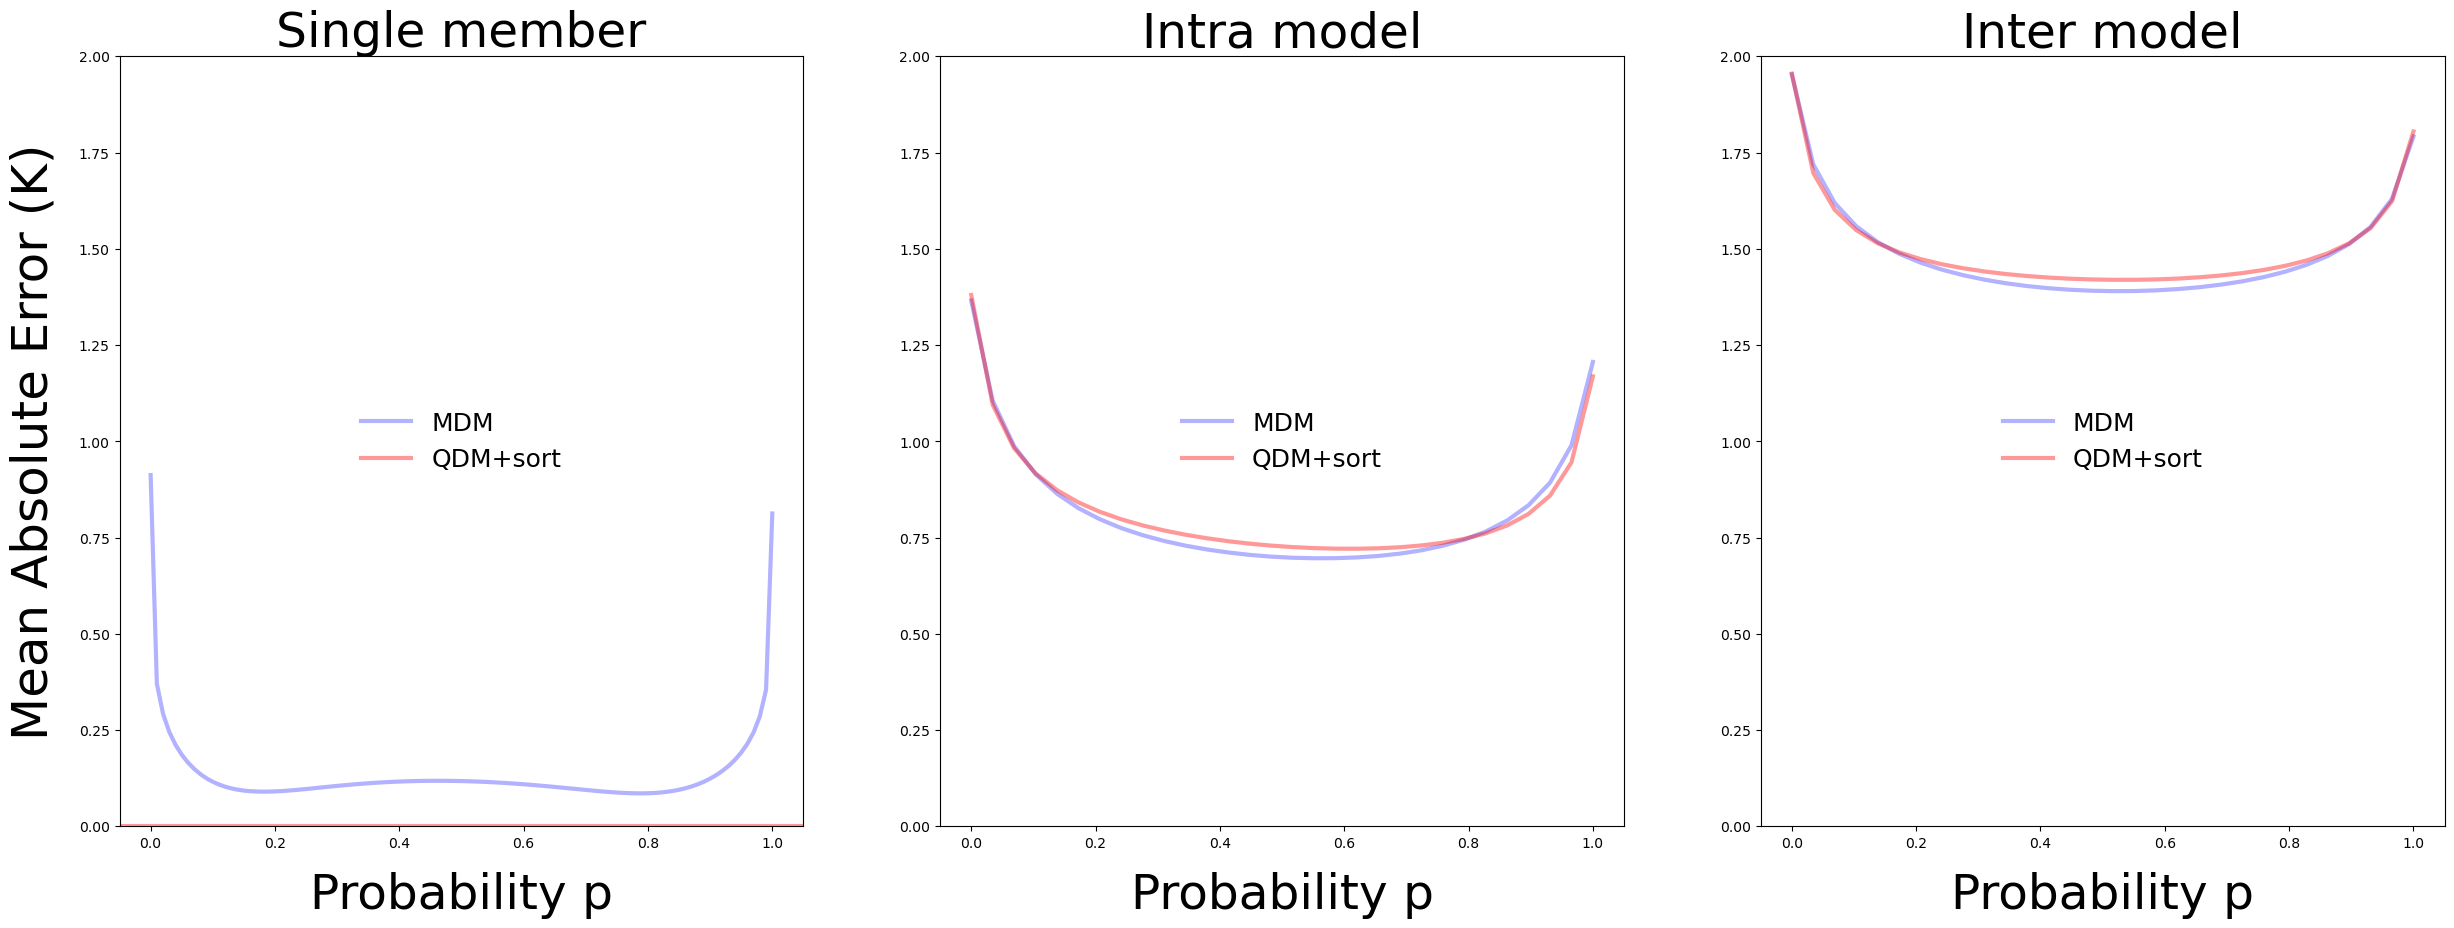

In [28]:
%%time
# Plot the 3 figures as a 3-panel plot
# Setting up the figure and subplots
quants30        = np.linspace(0,1.0,30)
fig, axs = plt.subplots(1, 3, figsize=(30, 10)) # 3 plots - side by side

#Plot for single model
axs[0].plot(quants,qgmsc_gmae,'b', label ='MDM',lw=3,alpha=0.3)
axs[0].axhline(y=0,color='r',label='QDM+sort',lw=3,alpha=0.4)
axs[0].set_ylabel('Mean Absolute Error (K)',fontweight=500,fontsize=36,labelpad=15)
axs[0].set_xlabel('Probability p',fontweight=500,fontsize=35,labelpad=15)
axs[0].set_title('Single member',fontweight=500,fontsize=35)
axs[0].legend(loc='center',prop={'size': 18},frameon= False)
axs[0].tick_params(axis='both', which='minor', labelsize=20)
axs[0].set_ylim([0.0,2.0])

#Intra model error
axs[1].plot(quants30,average_mdm_mae ,'b', label ='MDM',lw=3,alpha=0.3)
axs[1].plot(quants30,average_sqdm_mae ,'r',label='QDM+sort',lw=3,alpha=0.4)
axs[1].set_xlabel('Probability p',fontweight=500,fontsize=35,labelpad=15)
axs[1].set_title('Intra model',fontweight=500,fontsize=35)
axs[1].legend(loc='center',prop={'size': 18},frameon= False)
axs[1].tick_params(axis='both', which='minor', labelsize=20)
axs[1].set_ylim([0.0,2.0])

#Inter model error
axs[2].plot(quants30,cmip6_average_mdm_mae ,'b', label ='MDM',lw=3,alpha=0.3)
axs[2].plot(quants30,cmip6_average_sqdm_mae ,'r',label='QDM+sort',lw=3,alpha=0.4)
axs[2].set_xlabel('Probability p',fontweight=400,fontsize=35,labelpad=15)
axs[2].set_title('Inter model',fontweight=400,fontsize=35)
axs[2].legend(loc='center',prop={'size': 18},frameon=False)
axs[2].tick_params(axis='both', which='minor', labelsize=20)
axs[2].set_ylim([0.0,2.0])

In [ ]:
cmip6_average_mdm_mae.values

In [ ]:
cmip6_average_sqdm_mae.values